In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve)

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud


In [2]:
df = pd.read_csv('amazonreviews.tsv', sep='\t')

In [3]:
df.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [4]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AKSHAT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\AKSHAT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
###datacleaning
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)


In [6]:
df['label'] = df['label'].map({'pos': 1, 'neg': 0})


In [7]:
###text processing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df['clean_review'] = df['review'].apply(preprocess_text)


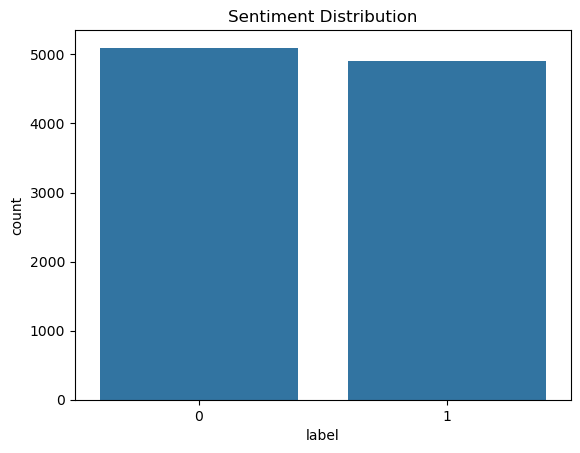

In [8]:
###EDA
sns.countplot(x=df['label'])
plt.title("Sentiment Distribution")
plt.show()


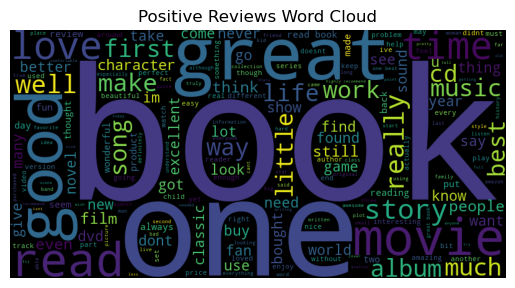

In [10]:
###wordcloud - positive reviews
positive_words = " ".join(df[df['label']==1]['clean_review'])
wordcloud = WordCloud(width=800, height=400).generate(positive_words)

plt.imshow(wordcloud)
plt.axis("off")
plt.title("Positive Reviews Word Cloud")
plt.show()


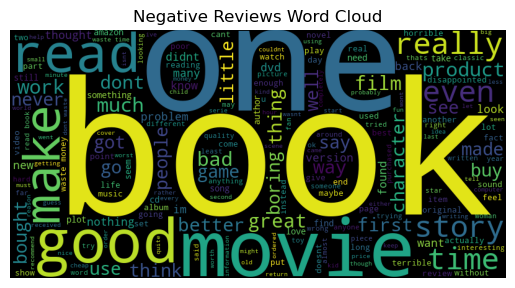

In [11]:
###wordcloud - negetive reviews
negative_words = " ".join(df[df['label']==0]['clean_review'])
wordcloud = WordCloud(width=800, height=400).generate(negative_words)

plt.imshow(wordcloud)
plt.axis("off")
plt.title("Negative Reviews Word Cloud")
plt.show()


In [13]:
###feature extraction
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    min_df=5
)

x = tfidf.fit_transform(df['clean_review'])
y = df['label']


In [14]:
### feature extraction
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)


In [16]:
###Naive Bayes Model – HYPERPARAMETER TUNING ADDED
alphas = [0.1, 0.5, 1.0, 2.0]
results = {}

for a in alphas:
    nb = MultinomialNB(alpha=a)
    nb.fit(x_train, y_train)
    preds = nb.predict(x_test)
    results[a] = accuracy_score(y_test, preds)

results


{0.1: 0.8425, 0.5: 0.841, 1.0: 0.8415, 2.0: 0.841}

In [17]:
best_alpha = max(results, key=results.get)
best_alpha


0.1

In [19]:
final_model = MultinomialNB(alpha=best_alpha)
final_model.fit(x_train, y_train)

y_pred = final_model.predict(x_test)
y_prob = final_model.predict_proba(x_test)[:,1]


In [20]:
###accuracy and classififcation report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8425
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1019
           1       0.85      0.83      0.84       981

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



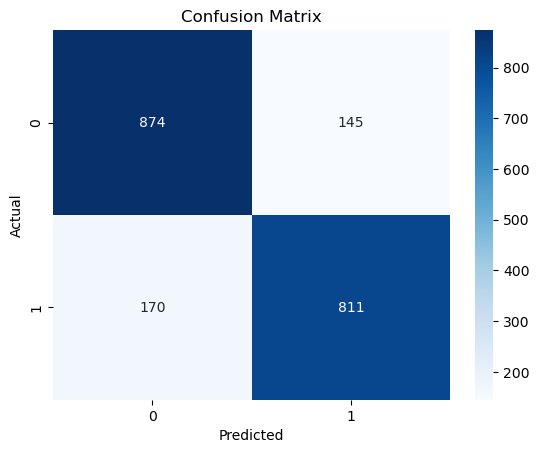

In [21]:
###confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


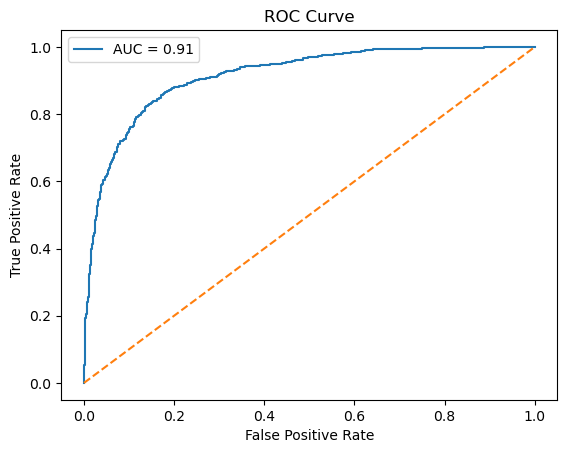

In [22]:
###roc curve
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
